In [1]:
import pandas as pd
import numpy as np

import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
from rasterio.windows import from_bounds
import xarray as xr
import rioxarray as rioxr

import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import latex

import yaml

from utils import geo, data

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import atlite
from atlite.gis import ExclusionContainer

import matplotlib.pyplot as plt; plt.style.use('seaborn-colorblind')
import matplotlib.colors as pltc
import style; figsize = style.configure(document_fontsize = 10.95, available_width = 394.78204)
from style import lighten_color

### 0 . Preliminaries

In [2]:
ROOT = 'C:/Users/49176/Uni/Masterthesis/'
LUISA = ROOT + 'data/input_geodata/luisa.tif'
CORINE = ROOT + 'data/input_geodata/corine.tif'

# Excel with necessary information on the shapes luisa / corine cover, as well as the gridcodes
gc_excel = pd.read_excel(ROOT + 'data/gridcode_dict.xlsx', sheet_name = 'py_dict_format', 
                         converters = {'in_gc_luisa' : int, 'in_gc_corine' : int, 'ex_gc_luisa' : int, 'ex_gc_corine': int})

gridcodes = {
    'inclusion' : 
    {
        'luisa' : dict(zip(gc_excel['in_gc_type'], gc_excel['in_gc_luisa'])),
        'corine' : dict(zip(gc_excel['in_gc_type'], gc_excel['in_gc_corine']))
    },
    'exclusion' :
    {
        'luisa' : dict(zip(gc_excel['ex_gc_type_luisa'].dropna(), gc_excel['ex_gc_luisa'].dropna())),
        'corine' : dict(zip(gc_excel['ex_gc_type_corine'].dropna(), gc_excel['ex_gc_corine'].dropna()))
    }
}

clrs = {'darkblue' : plt.rcParams['axes.prop_cycle'].by_key()['color'][0],
         'green' : plt.rcParams['axes.prop_cycle'].by_key()['color'][1],
         'orange' : plt.rcParams['axes.prop_cycle'].by_key()['color'][2],
         'pink' : plt.rcParams['axes.prop_cycle'].by_key()['color'][3],
         'yellow' : plt.rcParams['axes.prop_cycle'].by_key()['color'][4],
         'lightblue' : plt.rcParams['axes.prop_cycle'].by_key()['color'][5]}


# Analysis

## 1. Introduction

## 2. Literature Review

## 3. Data

### 3.1 Pyhsical Potential

In [113]:
countries = ['France', 'Spain', 'Italy', 'Switzerland', 'Germany', 'Belgium']
shp = [gpd.read_file(ROOT + f'data/country_shapes/{cntry}.gpkg') for cntry in countries]

In [ ]:
src = []
root = ROOT + f'data/era5/France/'

for i in pd.date_range('2011' , '2022', freq = 'Y').strftime('%Y'): 
    
    src.append(f'{root}{i}.nc')            
               
cutout = geo.merge_cutouts(src)
wnd100m = cutout.data['wnd100m']

In [115]:
gwa = rioxr.open_rasterio(ROOT + 'data/gwa/France_wind-speed_100m.tif') 

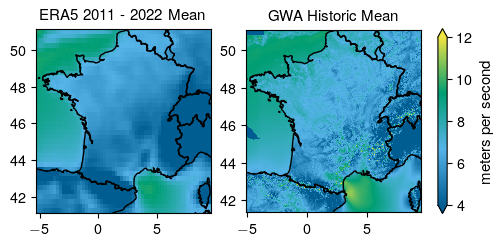

In [19]:
cmap = pltc.LinearSegmentedColormap.from_list("", [lighten_color(clrs['darkblue'],1.1), clrs['lightblue'], clrs['green'] ,clrs['yellow']])

fig, ax = plt.subplots(1,2,figsize = figsize(1), dpi = 100)


cbar_kwargs = {'label':'meters per second'}

# Era5
era = wnd100m.mean('time').plot(cmap = cmap, ax=ax[0],  add_colorbar = False, vmin = 4, vmax = 12)
for country in shp:
    country.plot(facecolor = 'none', edgecolor ='k',  ax=ax[0]) 
    
ax[0].set_ylabel(None); ax[0].set_xlabel(None)
ax[0].set_title('ERA5 2011 - 2022 Mean') 


# GWA
glowa = gwa.plot(cmap = cmap, ax=ax[1], add_colorbar = False, vmin = 4, vmax = 12)

for country in shp:
    country.plot(facecolor = 'none', edgecolor ='k', ax=ax[1])
    
ax[1].set_xlim(shp[0].unary_union.bounds[0], shp[0].unary_union.bounds[2])
ax[1].set_ylim(shp[0].unary_union.bounds[1], shp[0].unary_union.bounds[3])

ax[1].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].set_title('GWA Historic Mean')

cbar = plt.colorbar(era, ax=ax.ravel().tolist(), shrink = 0.725, extend='both', fraction=0.05, pad=0.04, label = 'meters per second')
 

#fig.tight_layout(pad=0.1)
fig.savefig(ROOT + 'results/plots/era5_gwa.png', dpi = 200, facecolor = 'white')

### 3.2 Geographic Potential

### Figure 3.2.1

In [19]:
#States
shpfilename = shpreader.natural_earth(resolution='10m',
                                          category='cultural',
                                          name='admin_1_states_provinces_lines')
    
states = gpd.read_file(shpfilename)[['ADM0_NAME', 'NAME', 'geometry']]
berlin = states.to_crs(3035).query("NAME == 'Berlin - Brandenburg'")

Exception ignored in: <function BaseGeometry.__del__ at 0x000001CFF441D430>
Traceback (most recent call last):
  File "C:\Users\49176\AppData\Roaming\Python\Python39\site-packages\shapely\geometry\base.py", line 209, in __del__
    self._empty(val=None)
  File "C:\Users\49176\AppData\Roaming\Python\Python39\site-packages\shapely\geometry\base.py", line 194, in _empty
    self._lgeos.GEOSGeom_destroy(self.__geom__)
KeyboardInterrupt: 


In [20]:
from rasterio.windows import from_bounds

buffer = 5000

with rio.open(LUISA) as f:
    
    window = from_bounds(berlin.bounds['minx'].values - buffer,
                         berlin.bounds['miny'].values - buffer,
                         berlin.bounds['maxx'].values + buffer,
                         berlin.bounds['maxy'].values + buffer,
                         f.transform)
    
    luisa = f.read(1, window = window)
    transform_luisa = rio.windows.transform(window, f.transform)
    
    
with rio.open(CORINE) as f:
    
    window = from_bounds(berlin.bounds['minx'].values - buffer,
                         berlin.bounds['miny'].values - buffer,
                         berlin.bounds['maxx'].values + buffer,
                         berlin.bounds['maxy'].values + buffer,
                         f.transform)
    
    corine = f.read(1, window = window)
    transform_corine = rio.windows.transform(window, f.transform)
    
luisa_labs_cols = {'High density urban fabric' : clrs['darkblue'],
                   'Medium density urban fabric' : style.lighten_color(clrs['green'], 1.25), 
                   'Low density urban fabric' : clrs['green'],
                   'Isolated or very low density urban fabric' : style.lighten_color(clrs['green'], 0.75),              
                   'Industrial or commercial units' : clrs['orange'],
                   'Road and rail networks and associated land' : style.lighten_color(clrs['orange'], 1.25)}
    
corine_labs_cols = {'Continuous urban fabric' : clrs['darkblue'],
                    'Discontinuous urban fabric' : clrs['green'], 
                    'Industrial or commercial units' : clrs['orange'],
                    'Road and rail networks and associated land' : style.lighten_color(clrs['orange'], 1.25)}    

gc_luisa = [gridcodes['exclusion']['luisa'][i] for i in luisa_labs_cols.keys()]
gc_corine = [gridcodes['exclusion']['corine'][i] for i in corine_labs_cols.keys()]
    
luisa_plot = np.isin(luisa, [gc_luisa])  * luisa
corine_plot = np.isin(corine, [gc_corine])  * corine

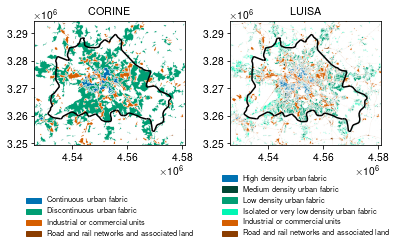

In [26]:
c_transparent = pltc.colorConverter.to_rgba('white',alpha = 0)

fig, ax = plt.subplots(1 , 2, figsize=figsize(1)) 

#left plot
patches = []

for g,l,c in zip(gc_corine, corine_labs_cols.keys(), corine_labs_cols.values()):
               
    cmap = pltc.LinearSegmentedColormap.from_list('rb_cmap',[c_transparent, c],512)
               

    show(np.isin(corine_plot, [g]) , transform = transform_corine, cmap = cmap, label = l, ax=ax[0])

    
patches = [mpatches.Patch(color=c, label=l) for l,c in zip(corine_labs_cols.keys(), corine_labs_cols.values())]
ax[0].legend(handles = patches, loc="lower center", bbox_to_anchor=(0.5, -0.8), ncol=1, frameon=False, fontsize = 'x-small')


berlin.plot(edgecolor = 'k', ax=ax[0])
ax[0].set_title('CORINE')


for g,l,c in zip(gc_luisa, luisa_labs_cols.keys(), luisa_labs_cols.values()):
               
    cmap = pltc.LinearSegmentedColormap.from_list('rb_cmap',[c_transparent, c],512)
               

    show(np.isin(luisa_plot, [g]) , transform = transform_luisa, cmap = cmap, label = l, ax=ax[1])
    
patches = [mpatches.Patch(color=c, label=l) for l,c in zip(luisa_labs_cols.keys(), luisa_labs_cols.values())]
ax[1].legend(handles = patches, loc="lower center", bbox_to_anchor=(0.5, -0.8), ncol=1, frameon=False,  fontsize = 'x-small')

berlin.plot(edgecolor = 'k', ax=ax[1])
ax[1].set_title('LUISA')

fig.tight_layout(pad=0.1)
fig.savefig(ROOT + 'results/plots/corine_luisa_berlin.pdf', bbox_inches = 'tight', dpi = 1000)

## 3.2.1 Table

In [24]:
do = False

if do == True:


    forest_d = {'Broad-leaved forest', 'Coniferous forest', 'Mixed forest'}


    with open(ROOT + "/windgenpotential/countrycode.yaml", 'r') as stream:
        countrycode = yaml.safe_load(stream)  

    countries = [i for i in countrycode.keys()]
    d = {}

    for cntry in countries:

        country = gpd.read_file(ROOT + f'data/country_shapes/{cntry}.gpkg').to_crs(3035)

        exc = ExclusionContainer(res=50)

        exc.add_raster(LUISA, codes = [gridcodes['inclusion']['luisa'][x] for x in forest_d], crs=3035, invert = True)

        forest = geo.mte(exc, country.geometry, share_kind = 'normal')

        d[cntry] = {'area' : forest[2], 'share' : forest[3]}

    forest_analysis = pd.DataFrame.from_dict(d, orient = 'index', columns = ['area', 'share'])
    #forest_analysis.to_csv(ROOT + 'results/forest_share.csv')

In [ ]:
cmap = pltc.LinearSegmentedColormap.from_list("", ["white",lighten_color(clrs['green'], 1.1)])

fig, ax = plt.subplots(figsize = figsize(1), dpi = 150)


divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.1)


for cntry in countries:
    country = gpd.read_file(ROOT + f'data/country_shapes/{cntry}.gpkg').to_crs(3035)
    country['share'] = forest_analysis.loc[cntry, 'share'] * 100
    if cntry == countries[0]:
        country.plot('share', edgecolor = 'k', lw = 0.1, cmap = cmap, vmin = 0, vmax = 65, legend = True, ax = ax, cax=cax)

    else:
        country.plot('share', edgecolor = 'k', lw = 0.1, cmap = cmap, vmin = 0, vmax = 65, legend = False, ax = ax)
        
cax.set_ylabel('percent', rotation = 270, labelpad = 15)        
ax.set_title('Forest share per country')

fig.tight_layout(pad=0.1)
fig.savefig(ROOT + 'results/plots/forest_share_map.pdf')
    

In [ ]:
forest_share_sorted = forest_analysis.sort_values('share')
mean = np.mean(forest_share_sorted.share)
areaweighted_mean = np.sum(forest_analysis.area * forest_analysis.share) / np.sum(forest_analysis.area)

fig, ax = plt.subplots(figsize = figsize(1)) 

labs = [countrycode[i] for i in forest_share_sorted.index]

bars = ax.bar(x=labs, 
              height = round(forest_share_sorted.share, 2),
              color = clrs['green'])



ax.axhline(mean, color = clrs['darkblue'])
ax.axhline(areaweighted_mean, color = clrs['orange'])

ax.annotate('Mean', xy = (0,mean+0.01), color = clrs['darkblue'], fontsize = 'small')
ax.annotate('Area weighted mean', xy = (0,areaweighted_mean+0.01), color = clrs['orange'], fontsize = 'small')

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))

plt.xticks(rotation = 90, fontsize = 'xx-small')

ax.set_title('LUISA: Forest share by country')

plt.show()

fig.tight_layout(pad=0.1)
fig.savefig(ROOT + 'results/plots/forest_share.pdf', dpi = 500)

## 3.2.2 Protected areas

In [129]:
#cdda = gpd.read_file(r'C:\CaT\Masterthesis\repository\data\input_geodata\WDPA_WDOECM_Nov2022_Public_EU\WDPA_WDOECM_Nov2022_Public_EU.gdb\a00000009.gdbtable')

C:\Users\Calvin\.conda\envs\atlite\lib\site-packages\geopandas\plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


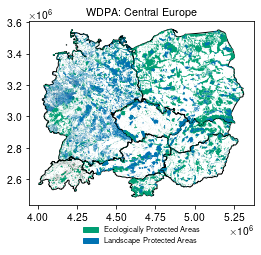

In [56]:
central_europe = ['Germany', 'Switzerland', 'Austria', 'Slovenia', 'Slovakia', 'Czech Republic', 'Hungary', 'Poland']

fig, ax = plt.subplots()

for cntry in central_europe:

    shape = gpd.read_file(ROOT + f'data/country_shapes/{cntry}.gpkg').to_crs(3035)
    pa =  gpd.read_file(ROOT + f'data/country_pa/{cntry}.gpkg')
    
    if cntry == 'Germany':
        shape.plot(facecolor = 'none', edgecolor = 'k', ax=ax)
        pa[pa['IUCN_CAT'] != 'V'].plot(color = clrs['green'] , ax=ax)
        pa[pa['IUCN_CAT'] == 'V'].plot(color = clrs['darkblue'] , ax=ax)
    else:
        shape.plot(facecolor = 'none', edgecolor = 'k', ax=ax)
        pa[pa['IUCN_CAT'] != 'V'].plot(color = clrs['green'], ax=ax)
        pa[pa['IUCN_CAT'] == 'V'].plot(color = clrs['darkblue'], ax=ax)

patches = [mpatches.Patch(color=c, label=l) for l,c in zip(['Ecologically Protected Areas', 'Landscape Protected Areas'],[clrs['green'],clrs['darkblue']])]   
ax.legend(handles = patches, loc = 'lower center', ncol = 1, bbox_to_anchor=(0.5, -0.25), frameon=False,  fontsize = 'x-small')

ax.set_title('WDPA: Central Europe')

fig.tight_layout(pad=0.1)
fig.savefig(ROOT + 'results/plots/pa.png', facecolor='w', dpi = 500)


## 3.2.3 Slopes

In [5]:
#Austria

country = gpd.read_file(ROOT + 'data/country_shapes/Austria.gpkg').to_crs(3035)

with rio.open(ROOT + 'data/input_geodata/EUD_CP_SLOP_mosaic/eudem_slop_3035_europe.tif') as src: 
    window = from_bounds(country.bounds['minx'].values, country.bounds['miny'].values, country.bounds['maxx'].values, country.bounds['maxy'].values, src.transform)
    slope = src.read(1, window=window)
    transform = rio.windows.transform(window, src.transform)
    
slope[slope == 0] = 250
 
slope = geo.dn_to_degrees(slope) 

In [16]:
#np.mean(slope)

np.max(slope)

84.94

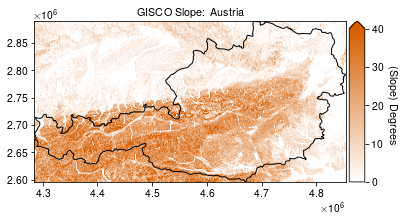

In [55]:
cmap = pltc.LinearSegmentedColormap.from_list("", ["white",lighten_color(clrs['orange'], 1)])

fig = plt.figure(figsize = figsize(1))
ax = plt.gca()

im = show(slope, transform = transform, cmap = cmap, ax=ax, vmin = 0, vmax = 40)
    
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)


ax.set_title('GISCO Slope: Austria')

plt.colorbar(im.get_images()[0], cax=cax, extend = 'max')
country.plot(facecolor = 'none', edgecolor = 'k', ax=ax)
cax.set_ylabel('(Slope) Degrees', rotation = 270, labelpad = 15)   

fig.tight_layout(pad=0.1)
fig.savefig(ROOT + 'results/plots/slope.pdf', dpi = 500)

## 4. Methodology

In [ ]:
country = gpd.read_file(ROOT + f'data/country_shapes/Luxembourg.gpkg').to_crs(3035)

In [130]:
exc = ExclusionContainer(res=50)

exc.add_raster(LUISA, codes = [2110], crs=3035, invert = True)

# Non irigated arable land
nial = geo.mte(exc, country.geometry, share_kind = 'normal')

C:\Users\49176\AppData\Roaming\Python\Python39\site-packages\atlite\gis.py:469: UserWarning: Output dtype of shape_availability changed from float to boolean.
  warn(


In [139]:
exc = ExclusionContainer(res=50)

exc.add_raster(LUISA, codes = [1122], crs=3035, invert = False, buffer = 1000)

# low density urban fabric
lduf = geo.mte(exc, country.geometry, share_kind = 'normal')

C:\Users\49176\AppData\Roaming\Python\Python39\site-packages\atlite\gis.py:469: UserWarning: Output dtype of shape_availability changed from float to boolean.
  warn(


In [140]:
exc = ExclusionContainer(res=50)

exc.add_raster(LUISA, codes = [2110], crs=3035, invert = True)
exc.add_raster(LUISA, codes = [1122], crs=3035, invert = False, buffer = 1000)

# Combination
comb = geo.mte(exc, country.geometry, share_kind = 'normal')

C:\Users\49176\AppData\Roaming\Python\Python39\site-packages\atlite\gis.py:469: UserWarning: Output dtype of shape_availability changed from float to boolean.
  warn(


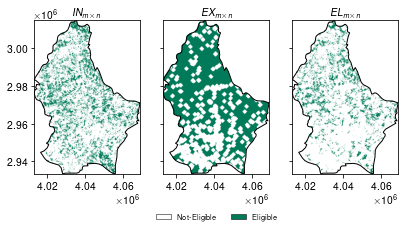

In [159]:
cmap = pltc.LinearSegmentedColormap.from_list("", ["white",lighten_color(clrs['green'], 1.1)])


fig, ax = plt.subplots(1, 3, figsize = figsize(1), sharey = True)

show(nial[0], transform = nial[1], ax = ax[0], cmap = cmap)
country.plot(facecolor = 'none', edgecolor = 'k', ax=ax[0])
ax[0].set_title(r'$IN_{m \times n}$')

show(lduf[0], transform = lduf[1], ax = ax[1], cmap = cmap)
country.plot(facecolor = 'none', edgecolor = 'k', ax=ax[1])
ax[1].set_title(r'$EX_{m \times n}$')

show(comb[0], transform = comb[1], ax = ax[2], cmap = cmap)
country.plot(facecolor = 'none', edgecolor = 'k', ax=ax[2])
ax[2].set_title(r'$EL_{m \times n}$')

patches = [mpatches.Patch(facecolor=c, edgecolor = 'k', lw = .5, label=l) for l,c in zip(['Not-Eligible', 'Eligible'],['white',lighten_color(clrs['green'], 1.1)])]   
ax[1].legend(handles = patches, loc = 'lower center', ncol = 2, bbox_to_anchor=(0.5, -0.35), frameon=False,  fontsize = 'x-small')


fig.tight_layout(pad=0.1)
fig.savefig(ROOT + 'results/plots/metho_eligibility.pdf', dpi = 500)

In [160]:
from scipy.ndimage import convolve

In [167]:
k = [[1,1,1],[1,0,1],[1,1,1]]

M = [[0, 1, 0, 1],
     [1, 1, 1, 1],
     [1, 1, 1, 1],
     [1, 0, 1, 0]]

convolve(M, k, mode = 'constant')

array([[3, 3, 5, 2],
       [4, 6, 7, 4],
       [4, 7, 6, 4],
       [2, 5, 3, 3]])

### Turbine Placement

In [10]:
with rio.open(ROOT + 'data/country_landuse_results/Luxembourg-base-1000-30-0-0.tif') as src: 
    el = src.read(1)
    transform = src.transform
    
with rio.open(ROOT + 'data/country_azimuth/Luxembourg-burned-azimuth.tif') as src: 
    az = src.read(1)
    
with rio.open(ROOT + 'data/country_turbine_decision/Luxembourg-Vestas_V90_3MW-Vestas_V112_3MW-burned-decision.tif') as src: 
    tt = src.read(1)

country = gpd.read_file(ROOT + 'data/country_shapes/luxembourg.gpkg')

In [5]:
turbine_dict = {1 : 90, 2 : 112}

tp = geo.place_n_turbines(res = 50,
                          landuse_av = el,
                          wind_dir = az[::-1],
                          turbine_type = tt[::-1], turbine_dict = turbine_dict,
                          r_radius_factor = 4,
                          c_radius_factor = 8,
                          return_ellipses = True)                       

Successfully built 644 turbines


In [30]:
import contextily as cx

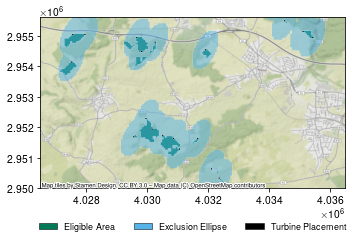

In [110]:
c_transparent = pltc.colorConverter.to_rgba('white',alpha = 0)
c_lightblue = pltc.colorConverter.to_rgba(clrs['lightblue'],alpha = .5)


cmap_el = pltc.LinearSegmentedColormap.from_list("", [c_transparent,lighten_color(clrs['green'], 1.1)])
cmap_ellipses = pltc.LinearSegmentedColormap.from_list("", [c_transparent, c_lightblue])
cmap_turbine = pltc.LinearSegmentedColormap.from_list("", [c_transparent, 'black'])



fig, ax = plt.subplots(figsize = figsize(1))


ax.set_ylim(2950000, 2955600)
ax.set_xlim(4026500, 4036500)

bm = cx.add_basemap(ax, crs = 'EPSG:3035', zoom = 14, attribution_size = 6)

#bm = ax 

show(el, transform = transform, ax = bm, cmap = cmap_el)
show(tp[2], transform = transform, ax = bm , cmap = cmap_ellipses)
show(tp[1], transform = transform, ax = bm, cmap = cmap_turbine, alpha = 1)


patches = [mpatches.Patch(facecolor=c, edgecolor = 'k', lw = .5, label=l) for l,c in zip(['Eligible Area', 'Exclusion Ellipse', 'Turbine Placement'],[lighten_color(clrs['green'], 1.1), clrs['lightblue'], 'black'])]   
ax.legend(handles = patches, loc = 'lower center', ncol = 3, bbox_to_anchor=(0.5, -0.3), frameon=False,  fontsize = 'small')


#fig.tight_layout(pad=0.1)
fig.savefig(ROOT + 'results/plots/placement_example.pdf', bbox_inches = 'tight', dpi = 500)


### MStR

In [105]:
fleet = pd.read_excel(r"C:\Users\49176\Uni\Masterthesis\presentations\MStR\Stromerzeuger.xlsx", sheet_name = 'hersteller')


In [108]:
fleet_on = fleet[fleet['Lage der Einheit'] == 'Windkraft an Land']

In [109]:
v90 = fleet_on[(fleet_on['hersteller_clean'] == 'Vestas Deutschland GmbH') & (fleet_on['typ_clean'].str.contains('90', na = False))]
v112 = fleet_on[(fleet_on['hersteller_clean'] == 'Vestas Deutschland GmbH') & (fleet_on['typ_clean'].str.contains('112', na = False))]

In [117]:
fleet_on['inbetriebnahme'].median()

Timestamp('2014-12-30 00:00:00')

In [116]:
print(len(fleet_on))
print(len(v90)) 
print(len(v112))

27616
3000
2346


In [110]:
(len(v90) + len(v112)) / len(fleet_on)

0.19358342989571262

In [112]:
print(v90['inbetriebnahme'].mean())
print(v112['inbetriebnahme'].mean())

2009-07-14 21:38:52.800000
2015-07-10 02:15:02.301790208


In [189]:
import math
print(3000000 / (math.pi * (90/2)**2))
print(3000000 / (math.pi * (112/2)**2))
print(4800000 / (math.pi * (151/2)**2))
print(5200000 / (math.pi * (165/2)**2))

471.570201753764
304.5056309156161
268.03867438835056
243.1899222267345


In [178]:
V_w2e_165 =  [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 20, 20]
POW_w2e_165 = [0.000, 0.000, 0.097, 0.321, 0.691, 1.237, 1.992, 2.930, 3.934, 4.649, 5.041, 5.193, 5.200, 5.200, 0]

V_w2e_151 = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20, 20]
POW_w2e_151 = [0.000, 0.000, 0.045, 0.2671, 0.5945, 1.0688, 1.6873, 2.483, 3.3945, 4.22555, 4.6945, 4.800, 4.800, 0]

V_V_90 = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 25, 25]
POW_V_90 = [0.000, 0.000, 0.000, 0.065, 0.195, 0.340, 0.570, 0.880, 1.270, 1.710, 2.140, 2.540, 2.830, 2.995, 3.000, 3.000, 0.000]

V_V_112 = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 25, 25]
POW_V_112 = [0.000, 0.000, 0.005, 0.115, 0.300, 0.550, 0.945, 1.375, 1.960, 2.525, 2.950, 2.990, 3.000, 3.000, 0.000]

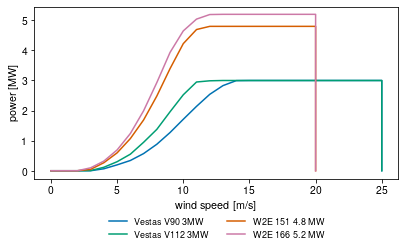

In [187]:
fig, ax = plt.subplots(figsize = figsize(1)) 

ax.plot(V_V_90, POW_V_90, label = 'Vestas V90 3MW')
ax.plot(V_V_112, POW_V_112, label = 'Vestas V112 3MW')

ax.plot(V_w2e_151, POW_w2e_151, label = 'W2E 151 4.8 MW')
ax.plot(V_w2e_165, POW_w2e_165, label = 'W2E 166 5.2 MW')

ax.set_ylabel('power [MW]')
ax.set_xlabel('wind speed [m/s]')

ax.legend(loc = 'lower center', ncol = 2, bbox_to_anchor=(0.5, -0.4), frameon=False,  fontsize = 'small')

fig.tight_layout(pad=0.1)
fig.savefig(ROOT + 'results/plots/power_curves.pdf', bbox_inches = 'tight', dpi = 200)


In [525]:
file = r"C:\Users\49176\Uni\Masterthesis\data\country_turbine_decision\France-W2E_151_4800kW-W2E_165_5200kW-burned-decision.tif"

with rio.open(file, 'r') as src: 
    fr_t = src.read(1)
    t = src.transform
    src.close()

<AxesSubplot:>

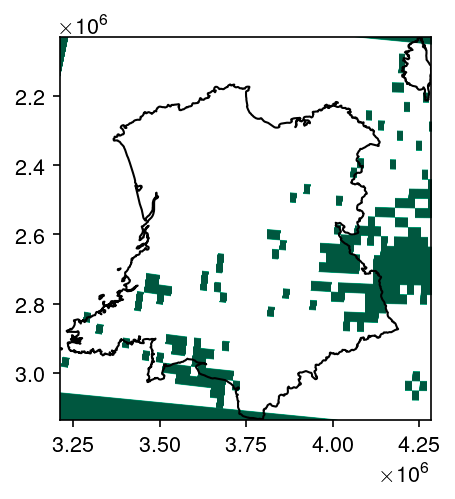

In [526]:
fig, ax = plt.subplots(dpi = 150)
gpd.read_file(ROOT + 'data/country_shapes/France.gpkg').to_crs(3035).plot(ax=ax, facecolor = 'none', edgecolor = 'k')
show(fr_t[::-1], transform = t, ax=ax, cmap = cmap)

## 5. Results

### 5.1 Geo Potential

In [208]:
# Landuse eli vars 

uds = [400, 600, 800, 1000]
slopes = [15,30]
fshares = [0, 5, 10]
lshares = [0, 5, 10]

with open(ROOT + "/windgenpotential/countrycode.yaml", 'r') as stream:
    countrycode = yaml.safe_load(stream)  

countries = [i for i in countrycode.keys()]

#not_ready = ['Spain', 'Sweden', 'United Kingdom', 'Norway']

#for nr in not_ready:
#    countries.remove(nr)

In [456]:
area_tot = {}

for cntry in countries: 
    v = gpd.read_file(ROOT + f'data/country_shapes/{cntry}.gpkg').to_crs(3035).area
    area_tot[cntry] = v.values

area_tot = pd.DataFrame(area_tot).T
area_tot.columns = ['area_tot']

In [457]:
from itertools import product

lu = []

for cntry, ud, slope, fshare, lshare in product(countries, uds, slopes, fshares, lshares):

    with rio.open(ROOT + f'data/country_landuse_results/{cntry}-base-{ud}-{slope}-{fshare}-{lshare}.tif') as f:
        v = f.read(1)
        f.close()
        v_area = v.sum() * 50**2
        v_share = v_area / area_tot.loc[cntry].values[0]
                                                
        lu.append([cntry, ud, slope, fshare, lshare, v_area, v_share])
        
lu = pd.DataFrame(lu, columns = ['country', 'ud', 'slope', 'fshare', 'lshare', 'v_area', 'v_share'])

lu.to_csv(ROOT+'results/lu.csv')

In [313]:
lu = pd.read_csv(ROOT + 'results/lu.csv')

In [314]:
lu_ud = lu[['country', 'ud', 'v_share']].groupby(['country', 'ud']).mean().unstack()
lu_slope = lu[['country', 'slope', 'v_share']].groupby(['country', 'slope']).mean().unstack()
lu_fshare = lu[['country', 'fshare', 'v_share']].groupby(['country', 'fshare']).mean().unstack()
lu_lshare = lu[['country', 'lshare', 'v_share']].groupby(['country', 'lshare']).mean().unstack()

In [315]:
def divide_by_first(row):
    return (row / row[0]) 
    
lu_ud_mod = lu_ud.iloc[:, ::-1].apply(divide_by_first, axis=1)
lu_slope_mod = lu_slope.apply(divide_by_first, axis=1)
lu_fshare_mod = lu_fshare.apply(divide_by_first, axis=1)
lu_lshare_mod = lu_lshare.apply(divide_by_first, axis=1)

In [316]:
min_max = pd.concat([lu[['country', 'ud', 'v_share']].groupby(['country', 'ud']).min().unstack().iloc[:,3],
                    lu[['country', 'ud', 'v_share']].groupby(['country', 'ud']).max().unstack().iloc[:,0]], axis = 1)
min_max['diff'] = min_max.iloc[:,1] - min_max.iloc[:,0]

### 5.1.0 Min Max Comparison

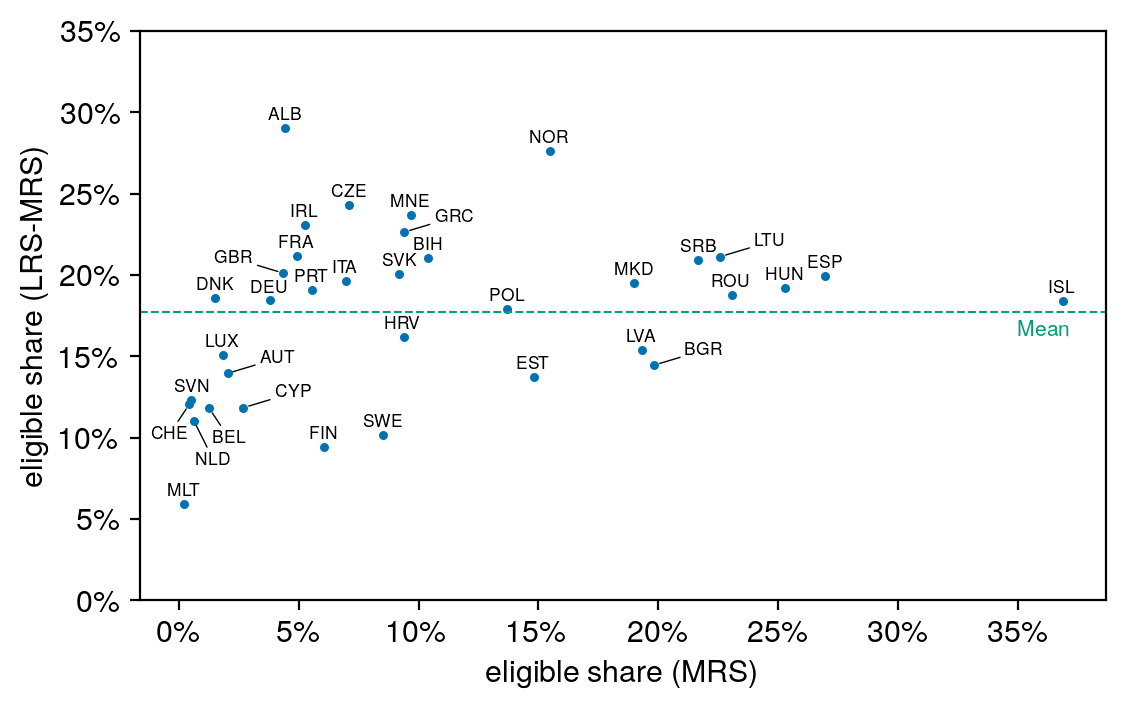

In [465]:
min_max.sort_values('diff').mean()

fig, ax = plt.subplots(figsize = figsize(1), dpi = 200)

ax.scatter(x = min_max.iloc[:,0]*100, y = min_max.iloc[:,2]*100, color = clrs['darkblue'], s = 5)
ax.set_ylim(0, 35)
#ax.set_xlim(right = 27)

ax.axhline(min_max.iloc[:,2].mean()*100, label = 'Mean', ls = '--', lw = 0.75, color = clrs['green'])

ax.annotate('Mean', (35, min_max.iloc[:,2].mean()*100), fontsize = 'x-small', xytext=(0,-25), textcoords="offset pixels", color = clrs['green'])

for i, txt in enumerate([countrycode[i] for i in countries]):
    
    if txt == 'BGR':
        ax.annotate(txt, ((min_max.iloc[:,0]*100)[i], (min_max.iloc[:,2]*100)[i]), ha='center',  va='center', xytext=(50,15), textcoords="offset pixels", fontsize = 'xx-small',
           arrowprops=dict(arrowstyle="-", connectionstyle="arc3", lw = .5), bbox=dict(boxstyle="round,pad=0", facecolor = 'none', edgecolor = 'none'))
    elif txt == 'LTU':
        ax.annotate(txt, ((min_max.iloc[:,0]*100)[i], (min_max.iloc[:,2]*100)[i]), ha='center', va='center', xytext=(50,15), textcoords="offset pixels", fontsize = 'xx-small',
           arrowprops=dict(arrowstyle="-", connectionstyle="arc3", lw = .5), bbox=dict(boxstyle="round,pad=0", facecolor = 'none', edgecolor = 'none'))
    elif txt == 'GRC':
        ax.annotate(txt, ((min_max.iloc[:,0]*100)[i], (min_max.iloc[:,2]*100)[i]), ha='center', va='center', xytext=(50,15), textcoords="offset pixels", fontsize = 'xx-small',
           arrowprops=dict(arrowstyle="-", connectionstyle="arc3", lw = .5), bbox=dict(boxstyle="round,pad=0", facecolor = 'none', edgecolor = 'none'))
    elif txt == 'CYP':
        ax.annotate(txt, ((min_max.iloc[:,0]*100)[i], (min_max.iloc[:,2]*100)[i]), ha='center', va='center', xytext=(50,15), textcoords="offset pixels", fontsize = 'xx-small',
           arrowprops=dict(arrowstyle="-", connectionstyle="arc3", lw = .5), bbox=dict(boxstyle="round,pad=0", facecolor = 'none', edgecolor = 'none'))
    elif txt == 'AUT':
        ax.annotate(txt, ((min_max.iloc[:,0]*100)[i], (min_max.iloc[:,2]*100)[i]), ha='center', va='center', xytext=(50,15), textcoords="offset pixels", fontsize = 'xx-small',
           arrowprops=dict(arrowstyle="-", connectionstyle="arc3", lw = .5), bbox=dict(boxstyle="round,pad=0", facecolor = 'none', edgecolor = 'none'))
    elif txt == 'GBR':
        ax.annotate(txt, ((min_max.iloc[:,0]*100)[i], (min_max.iloc[:,2]*100)[i]), ha='center', va='center', xytext=(-50,15), textcoords="offset pixels", fontsize = 'xx-small',
           arrowprops=dict(arrowstyle="-", connectionstyle="arc3", lw = .5), bbox=dict(boxstyle="round,pad=0", facecolor = 'none', edgecolor = 'none'))

        
    elif txt == 'NLD':
        ax.annotate(txt, ((min_max.iloc[:,0]*100)[i], (min_max.iloc[:,2]*100)[i]), ha='center', va='center', xytext=(20,-40),textcoords="offset pixels", fontsize = 'xx-small',
           arrowprops=dict(arrowstyle="-", connectionstyle="arc3", lw = .5), bbox=dict(boxstyle="round,pad=0", facecolor = 'none', edgecolor = 'none'))
    elif txt == 'CHE':
        ax.annotate(txt, ((min_max.iloc[:,0]*100)[i], (min_max.iloc[:,2]*100)[i]), ha='center', va='center', xytext=(-20,-30),textcoords="offset pixels", fontsize = 'xx-small',
           arrowprops=dict(arrowstyle="-", connectionstyle="arc3", lw = .5), bbox=dict(boxstyle="round,pad=0", facecolor = 'none', edgecolor = 'none'))
        
    elif txt == 'BEL':
        ax.annotate(txt, ((min_max.iloc[:,0]*100)[i], (min_max.iloc[:,2]*100)[i]), ha='center', va='center', xytext=(20,-30),textcoords="offset pixels", fontsize = 'xx-small',
           arrowprops=dict(arrowstyle="-", connectionstyle="arc3", lw = .5), bbox=dict(boxstyle="round,pad=0", facecolor = 'none', edgecolor = 'none'))   
        
    else:   
        ax.annotate(txt, ((min_max.iloc[:,0]*100)[i], (min_max.iloc[:,2]*100)[i]), ha='center', xytext=(0,8), textcoords="offset pixels", fontsize = 'xx-small')

ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

ax.set_xlabel('eligible share (MRS)')
ax.set_ylabel('eligible share (LRS-MRS)')

#ax.legend(loc = 'lower center', ncol = 3, bbox_to_anchor=(0.5, -0.3), frameon=False,  fontsize = 'small')

fig.tight_layout(pad=0.1)
fig.savefig(ROOT + 'results/plots/landuse_min_max.png', dpi = 200)




In [466]:
np.corrcoef(min_max.iloc[:,0],min_max.iloc[:,2])

array([[1.        , 0.28852322],
       [0.28852322, 1.        ]])

In [472]:
countries[0]

'Albania'

### 5.1.1 Urban Fabric

In [715]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

do = False

if do == True:

    uf_d = {'High density urban fabric', 'Medium density urban fabric',
            'Low density urban fabric', 'Isolated or very low density urban fabric',
            'Urban vegetation', 'Industrial or commercial units', 'Major stations', 'Port areas'
            }
    
    d = {}

    for cntry in countries:
        
        print(cntry)

        country = gpd.read_file(ROOT + f'data/country_shapes/{cntry}.gpkg').to_crs(3035)
        exc = ExclusionContainer(res=50)
        exc.add_raster(LUISA, codes = [gridcodes['exclusion']['luisa'][x] for x in uf_d], crs=3035, invert = True)
        uf = geo.mte(exc, country.geometry, share_kind = 'normal')
        d[cntry] = {'uf_area' : uf[2], 'uf_share' : uf[3]}
        
        del uf
        
        exc = ExclusionContainer(res=50)
        exc.add_raster(LUISA, codes = [gridcodes['exclusion']['luisa']['Isolated or very low density urban fabric']], crs=3035, invert = True)
        uf = geo.mte(exc, country.geometry, share_kind = 'normal')
        d[cntry]['iuf_area'] = uf[2] 
        d[cntry]['iuf_share'] = uf[3]
        
        del uf
        
        exc = ExclusionContainer(res=50)
        exc.add_raster(LUISA, codes = [gridcodes['exclusion']['luisa'][x] for x in ['Medium density urban fabric', 'High density urban fabric']], crs=3035, invert = True)
        uf = geo.mte(exc, country.geometry, share_kind = 'normal')
        d[cntry]['huf_area'] = uf[2] 
        d[cntry]['huf_share'] = uf[3]
        
        del uf
        
    uf_analysis = pd.DataFrame.from_dict(d, orient = 'index', columns = ['uf_area', 'uf_share', 'iuf_area', 'iuf_share', 'huf_area', 'huf_share'])
    uf_analysis.to_csv(ROOT + 'results/uf_analysis.csv')

Albania
Austria
Belgium
Bosnia and Herzegovina
Bulgaria
Croatia
Cyprus
Czech Republic
Denmark
Estonia
Finland
France
Germany
Greece
Hungary
Iceland
Ireland
Italy
Latvia
Lithuania
Luxembourg
Malta
Montenegro
Netherlands
Norway
Poland
Portugal
North Macedonia
Romania
Serbia
Slovakia
Slovenia
Spain
Sweden
Switzerland
United Kingdom


In [744]:
uf_analysis.sort_values('uf_share')

,uf_area,uf_share,iuf_area,iuf_share,huf_area,huf_share
Iceland,1.448275e+08,0.001414,4.002500e+07,0.000391,7.925000e+06,0.000077
Norway,2.498265e+09,0.007820,1.529248e+09,0.004787,3.825750e+07,0.000120
Sweden,5.980878e+09,0.013405,3.466495e+09,0.007769,1.829925e+08,0.000410
Finland,4.918345e+09,0.014767,3.242020e+09,0.009734,5.557750e+07,0.000167
Montenegro,2.245625e+08,0.016359,1.234875e+08,0.008996,2.713250e+07,0.001977
Latvia,1.131682e+09,0.017525,6.689725e+08,0.010359,1.410250e+07,0.000218
Estonia,8.479850e+08,0.018507,5.190550e+08,0.011328,5.730000e+06,0.000125
North Macedonia,5.648550e+08,0.022251,2.525825e+08,0.009950,8.672750e+07,0.003416
Bosnia and Herzegovina,1.292630e+09,0.024941,8.794500e+08,0.016969,8.315500e+07,0.001604
Spain,1.264661e+10,0.025321,5.442842e+09,0.010898,1.997935e+09,0.004000


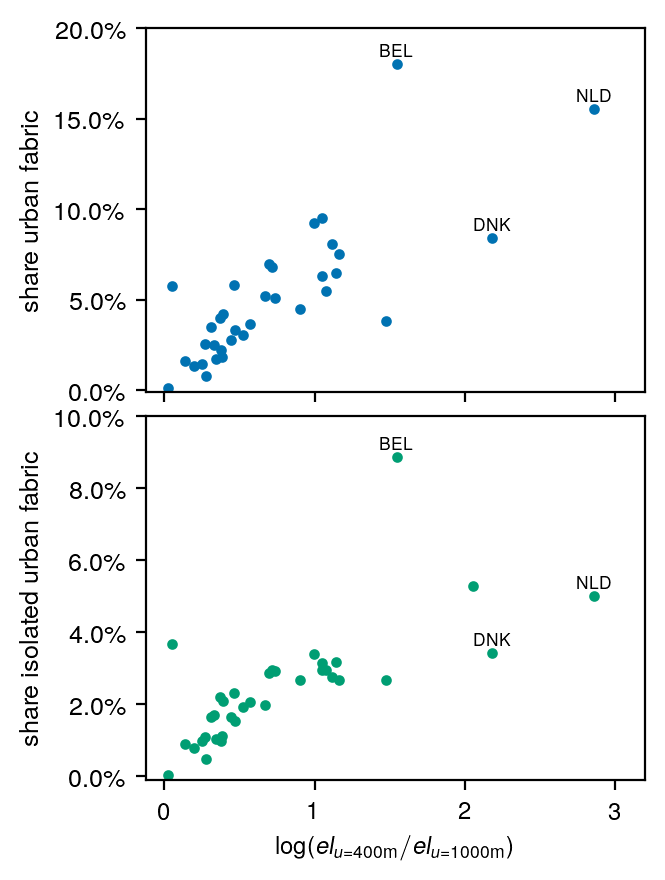

In [743]:
fig, ax = plt.subplots(2,1, figsize = (figsize(.575)[0], figsize(1)[1]*1.25), dpi = 200, sharex = True)

ax[0].scatter(y = uf_analysis.uf_share*100, x = np.log(lu_ud_mod.iloc[:,3]), color = clrs['darkblue'], s = 8)
ax[1].scatter(y = uf_analysis.iuf_share*100, x = np.log(lu_ud_mod.iloc[:,3]), color = clrs['green'], s = 8)

for i, txt in enumerate([countrycode[i] for i in countries]):
    if txt in ['NLD','DNK','BEL']:
        ax[0].annotate(txt, ((np.log(lu_ud_mod.iloc[:,3]))[i], (uf_analysis.uf_share*100)[i]), ha='center', xytext=(0,8), textcoords="offset pixels", fontsize = 'xx-small')
        ax[1].annotate(txt, ((np.log(lu_ud_mod.iloc[:,3]))[i], (uf_analysis.iuf_share*100)[i]), ha='center', xytext=(0,8), textcoords="offset pixels", fontsize = 'xx-small')

        
ax[0].set_ylabel('share urban fabric', size = 'small')
ax[1].set_ylabel('share isolated urban fabric', size = 'small')
ax[1].set_xlabel(r'$\log(el_{u\text{=400m}} / el_{u\text{=1000m}})$', size = 'small')


ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))

ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))


ax[0].set_ylim(bottom = -0.1, top=20)
ax[1].set_ylim(bottom = -0.1, top=10)


ax[0].set_xlim(right=3.2)
ax[1].set_xlim(right=3.2)



ax[0].tick_params(labelsize='small')
ax[1].tick_params(labelsize='small')

fig.tight_layout(pad=0.05)
fig.savefig(ROOT + 'results/plots/ud_scatter.png', dpi = 200)

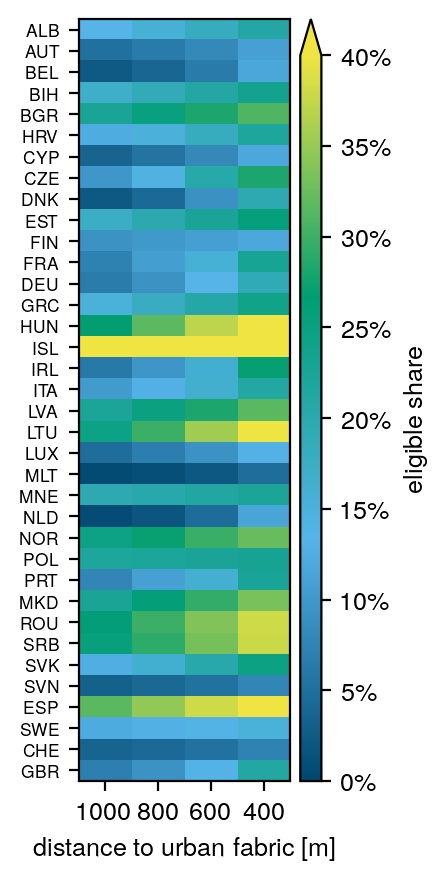

In [669]:
cmap = pltc.LinearSegmentedColormap.from_list(
    "", [lighten_color(clrs['darkblue'],1.2), clrs['lightblue'], clrs['green'], clrs['yellow']]
)


fig, ax = plt.subplots(dpi = 200, figsize = ((figsize(.375)[0], figsize(1)[1]*1.25)))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='10%', pad=0.05)


im = ax.imshow(lu_ud.iloc[:,::-1]*100, cmap=cmap, vmin = 0, vmax = 40, aspect = 'auto')
ax.set_yticks(range(len(countries)), [countrycode[i] for i in countries], size = 'xx-small')
ax.set_xticks([0,1,2,3], ['1000','800','600','400'], size = 'small')
ax.set_xlabel('distance to urban fabric [m]', size = 'small')
#ax.set_title('Area gain over 1000m distance')

cb = fig.colorbar(im, cax=cax, orientation='vertical', extend = 'max', format =  mtick.PercentFormatter(decimals=0))
cb.set_label(label='eligible share', fontsize = 'small')
cb.ax.tick_params(labelsize='small')

fig.tight_layout(pad=0.05)
fig.savefig(ROOT + 'results/plots/ud_heat.png', dpi = 200)

### 5.2 Slope 

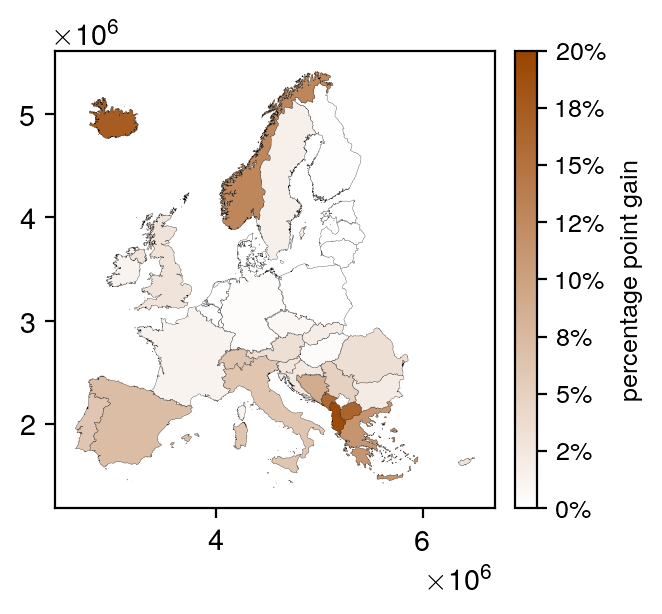

In [776]:
cmap = pltc.LinearSegmentedColormap.from_list("", ["white",lighten_color(clrs['orange'], 1.2)])

fig, ax = plt.subplots(figsize = (figsize(.575)[0], figsize(1)[1]*1.25), dpi = 200)


divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.1)


for cntry in countries:
    country = gpd.read_file(ROOT + f'data/country_shapes/{cntry}.gpkg').to_crs(3035)
    country['gain'] = (lu_slope.iloc[:,1]-lu_slope.iloc[:,0]).loc[cntry] * 100
    if cntry == countries[0]:
        country.plot('gain', edgecolor = 'k', lw = 0.1, cmap = cmap, vmin = 0, vmax = 20, legend = True, ax = ax, cax=cax)

    else:
        country.plot('gain', edgecolor = 'k', lw = 0.1, cmap = cmap, vmin = 0, vmax = 20, legend = False, ax = ax)
        
cax.set_ylabel('percentage point gain', fontsize = 'small')
cax.tick_params(labelsize='small')
cax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
#ax.set_title('Gain')

fig.tight_layout(pad=0.1)
fig.savefig(ROOT + 'results/plots/slope_gain.pdf')

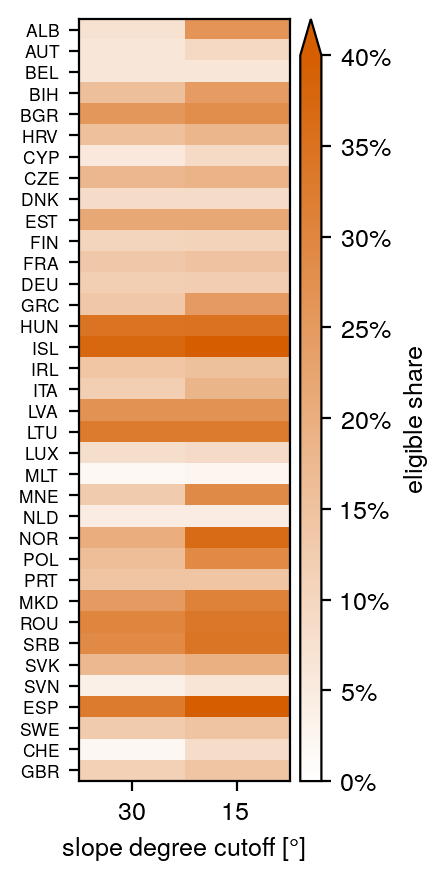

In [777]:
cmap = pltc.LinearSegmentedColormap.from_list(
    "", ['white', clrs['orange']]
)


fig, ax = plt.subplots(dpi = 200, figsize = ((figsize(.375)[0], figsize(1)[1]*1.25)))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='10%', pad=0.05)


im = ax.imshow(lu_slope *100, cmap=cmap, vmin = 0, vmax = 40, aspect = 'auto')
ax.set_yticks(range(len(countries)), [countrycode[i] for i in countries], size = 'xx-small')
ax.set_xticks([0,1], ['30','15'], size = 'small')
ax.set_xlabel('slope degree cutoff [°]', size = 'small')
#ax.set_title('Area gain over 1000m distance')

cb = fig.colorbar(im, cax=cax, orientation='vertical', extend = 'max', format =  mtick.PercentFormatter(decimals=0))
cb.set_label(label='eligible share', fontsize = 'small')
cb.ax.tick_params(labelsize='small')

fig.tight_layout(pad=0.05)
fig.savefig(ROOT + 'results/plots/slope_heat.png', dpi = 200)

In [334]:
lu_slope['diff'] = lu_slope.iloc[:,1] - lu_slope.iloc[:,0]

In [337]:
lu_slope.sort_values('diff', ascending = False)

v_share                diff
slope                         15        30          
country                                             
Albania                 0.074117  0.265621  0.191504
Iceland                 0.373475  0.546556  0.173081
North Macedonia         0.201861  0.367145  0.165284
Montenegro              0.128900  0.288717  0.159817
Norway                  0.160485  0.289179  0.128694
Greece                  0.137238  0.249952  0.112714
Bosnia and Herzegovina  0.157022  0.245875  0.088854
Spain                   0.329539  0.400046  0.070507
Switzerland             0.019942  0.083099  0.063158
Italy                   0.121761  0.183028  0.061267
Portugal                0.248944  0.309247  0.060303
Serbia                  0.289747  0.339274  0.049528
Romania                 0.302701  0.336466  0.033765
Austria                 0.060373  0.094130  0.033757
Cyprus                  0.057658  0.090179  0.032521
United Kingdom          0.113229  0.142996  0.029767
Slovenia                0.037011  0.064916  0.027905
Croatia                 0.156037  0.180734  0.024697
Bulgaria                0.257777  0.278934  0.021157
Slovakia                0.174928  0.195723  0.020795
Sweden                  0.126965  0.143860  0.016895
Ireland                 0.140664  0.154048  0.013384
France                  0.134592  0.147772  0.013181
Czech Republic          0.178000  0.186909  0.008909
Luxembourg              0.081058  0.088915  0.007857
Malta                   0.018118  0.024662  0.006544
Hungary                 0.344512  0.348653  0.004141
Germany                 0.118984  0.122843  0.003859
Belgium                 0.060880  0.062115  0.001236
Finland                 0.105303  0.106274  0.000971
Poland                  0.142716  0.143258  0.000542
Latvia                  0.268228  0.268595  0.000367
Lithuania               0.329130  0.329464  0.000334
Estonia                 0.214347  0.214617  0.000271
Denmark                 0.087306  0.087440  0.000134
Netherlands             0.046424  0.046462  0.000038

In [332]:
3.8 * 10**(-5)

3.8e-05

In [300]:
from scipy import stats
from rasterio.features import rasterize

do = True

if do:
    
    s = {}

    for cntry in countries: 

        print(cntry)

        country = gpd.read_file(ROOT + f'data/country_shapes/{cntry}.gpkg').to_crs(3035)

        with rio.open(ROOT + 'data/input_geodata/EUD_CP_SLOP_mosaic/eudem_slop_3035_europe.tif', 'r') as src:
            window = from_bounds(country.bounds['minx'].values, country.bounds['miny'].values, country.bounds['maxx'].values, country.bounds['maxy'].values, src.transform)
            d = src.read(1, window=window)
            r_shape = d.shape
            r_transform = rio.windows.transform(window, src.transform)
            
        data = rasterize(
            country.geometry,
            out_shape=r_shape,
            transform=r_transform,
            dtype='uint8'
        )
        
        m = np.mean((d*data)[(d*data) > 0])                      
        d15 = stats.percentileofscore((d*data)[(d*data) > 0].flatten(), score = 241)
        d30 = stats.percentileofscore((d*data)[(d*data) > 0].flatten(), score = 217)
        s[cntry] = [geo.dn_to_degrees(m), 100-d15, 100-d30] 

    s = pd.DataFrame(s).T
    s.columns = ['slope_mean', 'q_15', 'q_30']
    s['diff'] = s['q_30'] - s['q_15']


Albania
Austria
Belgium
Bosnia and Herzegovina
Bulgaria
Croatia
Cyprus
Czech Republic
Denmark
Estonia
Finland
France
Germany
Greece
Hungary
Iceland
Ireland
Italy
Latvia
Lithuania
Luxembourg
Malta
Montenegro
Netherlands
Norway
Poland
Portugal
North Macedonia
Romania
Serbia
Slovakia
Slovenia
Spain
Sweden
Switzerland
United Kingdom


In [344]:
lu_slope[:17]#['diff'].mean()

v_share                diff
slope                         15        30          
country                                             
Albania                 0.074117  0.265621  0.191504
Austria                 0.060373  0.094130  0.033757
Belgium                 0.060880  0.062115  0.001236
Bosnia and Herzegovina  0.157022  0.245875  0.088854
Bulgaria                0.257777  0.278934  0.021157
Croatia                 0.156037  0.180734  0.024697
Cyprus                  0.057658  0.090179  0.032521
Czech Republic          0.178000  0.186909  0.008909
Denmark                 0.087306  0.087440  0.000134
Estonia                 0.214347  0.214617  0.000271
Finland                 0.105303  0.106274  0.000971
France                  0.134592  0.147772  0.013181
Germany                 0.118984  0.122843  0.003859
Greece                  0.137238  0.249952  0.112714
Hungary                 0.344512  0.348653  0.004141
Iceland                 0.373475  0.546556  0.173081
Ireland                 0.140664  0.154048  0.013384

In [350]:
lu_slope.loc[s.sort_values('diff', ascending = False)[:17].index]['diff'].mean()

0.08437099176293195

In [355]:
che = gpd.read_file(ROOT + 'data/country_shapes/Switzerland.gpkg').to_crs(3035)
alb = gpd.read_file(ROOT + 'data/country_shapes/Albania.gpkg').to_crs(3035)

che_pa =  gpd.read_file(ROOT + 'data/country_pa/Switzerland.gpkg').to_crs(3035)
alb_pa =  gpd.read_file(ROOT + 'data/country_pa/Albania.gpkg').to_crs(3035)

<AxesSubplot:>

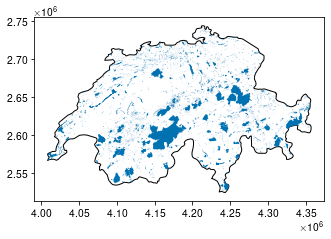

In [359]:
fig, ax = plt.subplots()

che.plot(facecolor = 'none', edgecolor = 'k', ax = ax)
#alb.plot(facecolor = 'none', edgecolor = 'k', ax = ax)

che_pa.plot(facecolor = clrs['darkblue'], ax = ax)
#alb_pa.plot(facecolor = 'none', edgecolor = 'k')

In [365]:
che_pa.geometry.area.sum() / che.geometry.area

0    0.151511
dtype: float64

<AxesSubplot:>

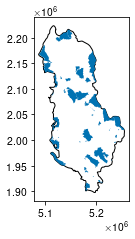

In [361]:
fig, ax = plt.subplots()

#che.plot(facecolor = 'none', edgecolor = 'k', ax = ax)
alb.plot(facecolor = 'none', edgecolor = 'k', ax = ax)

#che_pa.plot(facecolor = clrs['darkblue'], ax = ax)
alb_pa.plot(facecolor = clrs['darkblue'], ax = ax)

### 5.3 Forest & LPA share

In [491]:
from itertools import product
fshares = [0,5,10]
lshares = [0,5,10]

d = {}

for f,l in [(0,0), (5,0), (10,0), (0,5), (0,10), (5,5), (5,10), (10,5), (10,10)]: # product(fshares, lshares):
    
    d[f'(F{f}, L{l})'] = lu[(lu['fshare']==f) & (lu['lshare']==l)].groupby('country').mean()['v_share']

d = pd.DataFrame(d)
      

In [492]:
def divide_by_first(row):
    return (row - row[0]) 
    
d_mod = d.apply(divide_by_first, axis=1)
d_mod = d_mod.drop('(F0, L0)', axis = 1)

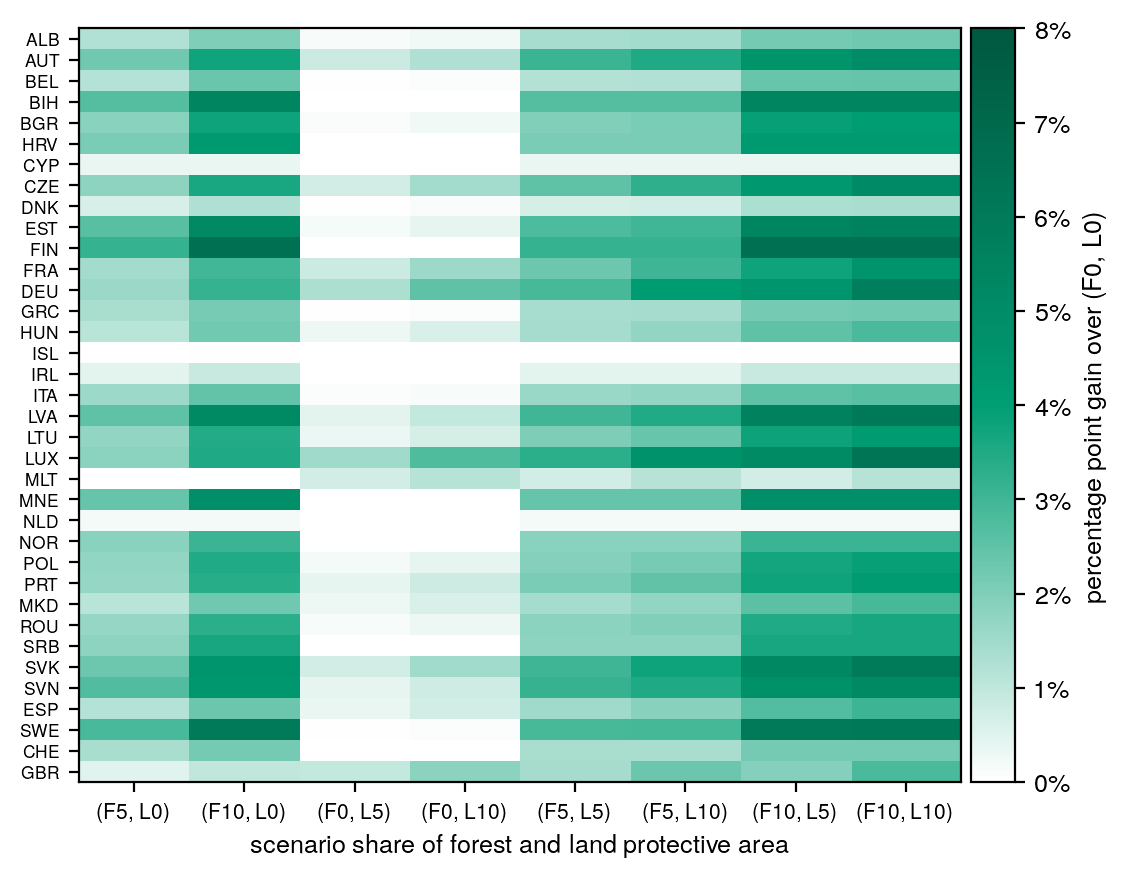

In [499]:
cmap = pltc.LinearSegmentedColormap.from_list(
    "", ['white', clrs['green'], lighten_color(clrs['green'], 1.2)]
)


fig, ax = plt.subplots(dpi = 200, figsize = ((figsize(1)[0], figsize(1)[1]*1.25)))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)


im = ax.imshow(d_mod *100, cmap=cmap, vmin = 0, vmax = 8, aspect = 'auto')
ax.set_yticks(range(len(countries)), [countrycode[i] for i in countries], size = 'xx-small')
ax.set_xticks([0,1,2,3,4,5,6,7], d_mod.columns, size = 'x-small')
ax.set_xlabel('scenario share of forest and land protective area', fontsize = 'small')


cb = fig.colorbar(im, cax=cax, orientation='vertical', format =  mtick.PercentFormatter(decimals=0))
cb.set_label(label='percentage point gain over (F0, L0)', fontsize = 'small')
cb.ax.tick_params(labelsize='small')

fig.tight_layout(pad=0.1)
fig.savefig(ROOT + 'results/plots/forest_lpa_heat.png', dpi = 200)

### 5.5 Turbine Placement

In [4]:
import glob 
import fiona 
from itertools import product

uds = ['1000' , '800', '600', '400']
ss = ['30', '15']
fs = ['0', '5', '10']
ls = ['0', '5', '10']
ts = ['Vestas_V90_3MW-Vestas_V112_3MW', 'W2E_151_4800kW-W2E_165_5200kW']

tps = []


with open(ROOT + "/windgenpotential/countrycode.yaml", 'r') as stream:
    countrycode = yaml.safe_load(stream)  

countries = [i for i in countrycode.keys()]

not_ready = ['Spain', 'Sweden', 'United Kingdom', 'Norway']
for nr in not_ready:
    countries.remove(nr)
      
for cntry in countries:
    
    print(cntry)
    
    for ud, s, f, l in product(uds, ss, fs, ls):
        
        with rio.open(ROOT + f'data/country_landuse_results/{cntry}-base-{ud}-{s}-{f}-{l}.tif') as src:
            v = src.read(1)
            src.close()
            area = v.sum() * 50**2
        
        for t in ts:
            file = ROOT + f'data/country_turbine_placements/{cntry}-base-{ud}-{s}-{f}-{l}-{t}.gpkg'
            d = fiona.open(file, 'r')     
            rows = len(d)
            d.close()

            tps.append([cntry, ud, s, f, l, t, area, rows])   

Albania
Austria
Belgium
Bosnia and Herzegovina
Bulgaria
Croatia
Cyprus
Czech Republic
Denmark
Estonia
Finland
France
Germany
Greece
Hungary
Iceland
Ireland
Italy
Latvia
Lithuania
Luxembourg
Malta
Montenegro
Netherlands
Poland
Portugal
North Macedonia
Romania
Serbia
Slovakia
Slovenia
Switzerland


In [5]:
tps_df = pd.DataFrame(tps, columns = ['country', 'ud', 'slope', 'fshare', 'lshare', 'turbine', 'area', 'placements'])

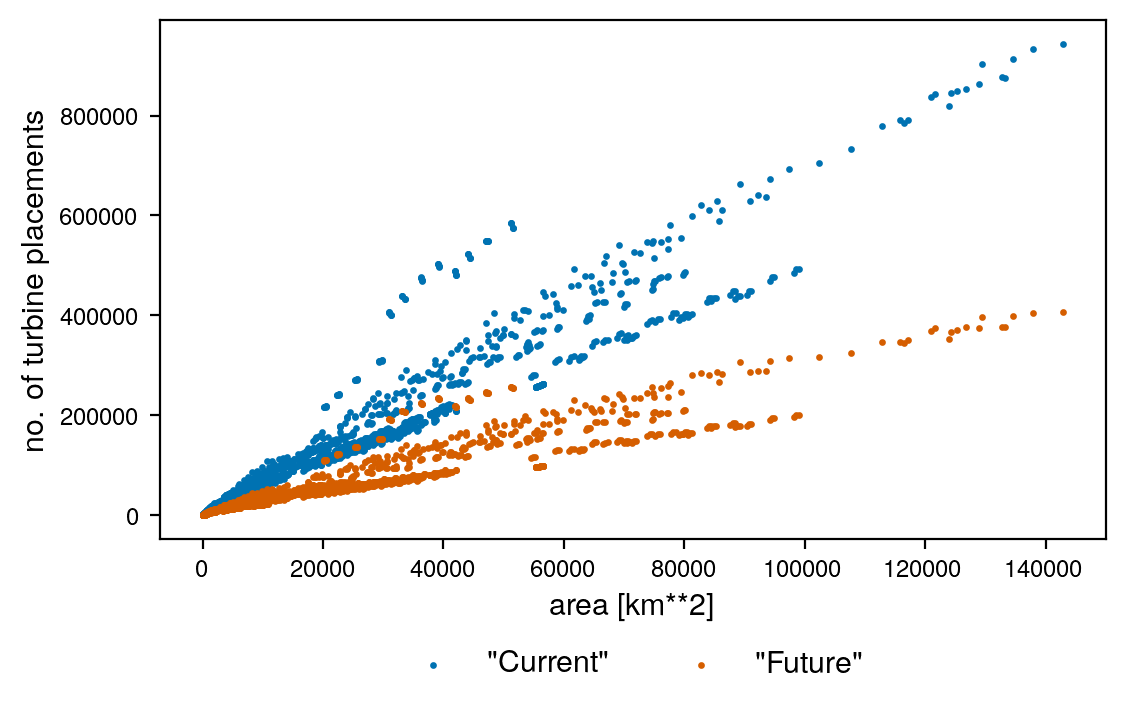

In [625]:
fig, ax = plt.subplots(figsize = figsize (1), dpi = 200)

ax.scatter(x = tps_df[tps_df['turbine'] == ts[0]].area/1000000, y = tps_df[tps_df['turbine'] == ts[0]].placements, s = 2, label = '"Current"')
ax.scatter(x = tps_df[tps_df['turbine'] == ts[1]].area/1000000, y = tps_df[tps_df['turbine'] == ts[1]].placements, s = 2, label = '"Future"', color = clrs['orange'])

ax.set_xlabel('area [km**2]')
ax.set_ylabel('no. of turbine placements')
ax.tick_params(labelsize='small')

ax.legend(loc = 'lower center', ncol = 2, bbox_to_anchor=(0.5, -0.325), frameon=False)

fig.tight_layout(pad=0.1)
fig.savefig(ROOT + 'results/plots/t_placement_area.pdf', dpi = 200)

In [636]:
import statsmodels.api as sm

In [59]:
tps_stats = tps_df[['country','placements', 'area']]
tps_stats['area'] = tps_stats['area']/1000000

tps_stats['turbine_dummy'] = (tps_df['turbine'] == 'Vestas_V90_3MW-Vestas_V112_3MW').astype(int)
tps_stats['turbine_dummy_area'] = tps_stats['turbine_dummy'] * tps_stats['area']

tps_stats = pd.get_dummies(tps_stats, columns=['country'])

C:\Users\49176\AppData\Local\Temp\ipykernel_3420\2134956767.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tps_stats['area'] = tps_stats['area']/1000000
C:\Users\49176\AppData\Local\Temp\ipykernel_3420\2134956767.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tps_stats['turbine_dummy'] = (tps_df['turbine'] == 'Vestas_V90_3MW-Vestas_V112_3MW').astype(int)
C:\Users\49176\AppData\Local\Temp\ipykernel_3420\2134956767.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [60]:
tps_stats

,placements,area,turbine_dummy,turbine_dummy_area,country_Albania,country_Austria,country_Belgium,country_Bosnia and Herzegovina,country_Bulgaria,country_Croatia,...,country_Montenegro,country_Netherlands,country_North Macedonia,country_Poland,country_Portugal,country_Romania,country_Serbia,country_Slovakia,country_Slovenia,country_Switzerland
0,32597,5700.7175,1,5700.7175,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,15517,5700.7175,0,0.0000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,32742,5744.1450,1,5744.1450,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15598,5744.1450,0,0.0000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,32763,5757.0600,1,5757.0600,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4603,10361,1934.5075,0,0.0000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4604,18774,1934.5075,1,1934.5075,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4605,10361,1934.5075,0,0.0000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4606,18774,1934.5075,1,1934.5075,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [61]:
#define response variable
y = tps_stats['placements'] 

In [69]:
import statsmodels.api as sm

#define predictor variables
x = tps_stats['area']

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             placements   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                 1.089e+04
Date:                Thu, 15 Dec 2022   Prob (F-statistic):               0.00
Time:                        19:20:08   Log-Likelihood:                -57632.
No. Observations:                4608   AIC:                         1.153e+05
Df Residuals:                    4606   BIC:                         1.153e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4314.1028   1287.584      3.351      0.0

In [67]:
x = tps_stats[['area','turbine_dummy_area']]

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:             placements   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                 2.180e+04
Date:                Thu, 15 Dec 2022   Prob (F-statistic):               0.00
Time:                        19:13:46   Log-Likelihood:                -55016.
No. Observations:                4608   AIC:                         1.100e+05
Df Residuals:                    4605   BIC:                         1.101e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               4314.1028    729

In [65]:
x = tps_stats.drop(['placements', 'turbine_dummy', 'turbine_dummy_area'], axis = 1)

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             placements   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     509.2
Date:                Thu, 15 Dec 2022   Prob (F-statistic):               0.00
Time:                        19:12:30   Log-Likelihood:                -56930.
No. Observations:                4608   AIC:                         1.139e+05
Df Residuals:                    4575   BIC:                         1.141e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [68]:
x = tps_stats.drop(['placements', 'turbine_dummy'], axis = 1)

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:             placements   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     7799.
Date:                Thu, 15 Dec 2022   Prob (F-statistic):               0.00
Time:                        19:14:36   Log-Likelihood:                -51101.
No. Observations:                4608   AIC:                         1.023e+05
Df Residuals:                    4574   BIC:                         1.025e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [74]:
import math
a = (math.pi * 8 * 4 * (0.5*(90+112)))
b = (math.pi * 8 * 4 * (0.5*(151+165)))
     
b/a

1.5643564356435644

In [85]:
fi_ro = tps_df[((tps_df['country']=='Finland') | (tps_df['country']=='Romania')) & 
               (tps_df['turbine'] == 'Vestas_V90_3MW-Vestas_V112_3MW')]
fi_ro_1000_15 = fi_ro[(fi_ro['ud'] == '1000') & (fi_ro['slope'] == '15')]

In [102]:
#15 00 > 15 5 5
#15 00 > 15 10 10 

#fi_1000_15_5_5 = 

fi_1000_15_0_0 = fi_ro_1000_15.query("(country == 'Finland') & (fshare == '0') & (lshare == '0')")
fi_1000_15_5_5 = fi_ro_1000_15.query("(country == 'Finland') & (fshare == '5') & (lshare == '5')")

ro_1000_15_0_0 = fi_ro_1000_15.query("(country == 'Romania') & (fshare == '0') & (lshare == '0')")
ro_1000_15_10_10 = fi_ro_1000_15.query("(country == 'Romania') & (fshare == '10') & (lshare == '10')")

In [114]:
(fi_1000_15_5_5.area.values - fi_1000_15_0_0.area.values) / 1000000

array([10812.84])

In [106]:
(ro_1000_15_10_10.area.values - ro_1000_15_0_0.area.values) / 1000000

array([8678.055])

In [111]:
(fi_1000_15_5_5.placements.values - fi_1000_15_0_0.placements.values)

array([189681], dtype=int64)

In [110]:
(ro_1000_15_10_10.placements.values - ro_1000_15_0_0.placements.values)

array([40177], dtype=int64)

In [118]:
with rio.open(ROOT + 'data/country_landuse_results/Finland-base-1000-15-0-0.tif', 'r') as src:
    fin0 = src.read(1)
    tf = src.transform
    src.close()
    
with rio.open(ROOT + 'data/country_landuse_results/Finland-base-1000-15-5-5.tif', 'r') as src:
    fin1 = src.read(1)
    tf = src.transform
    src.close()

In [ ]:
with rio.open(ROOT + 'data/country_landuse_results/Romania-base-1000-15-0-0.tif', 'r') as src:
    ro0 = src.read(1)
    rf = src.transform
    src.close()
    
with rio.open(ROOT + 'data/country_landuse_results/Romania-base-1000-15-10-10.tif', 'r') as src:
    ro1 = src.read(1)
    rf = src.transform
    src.close()

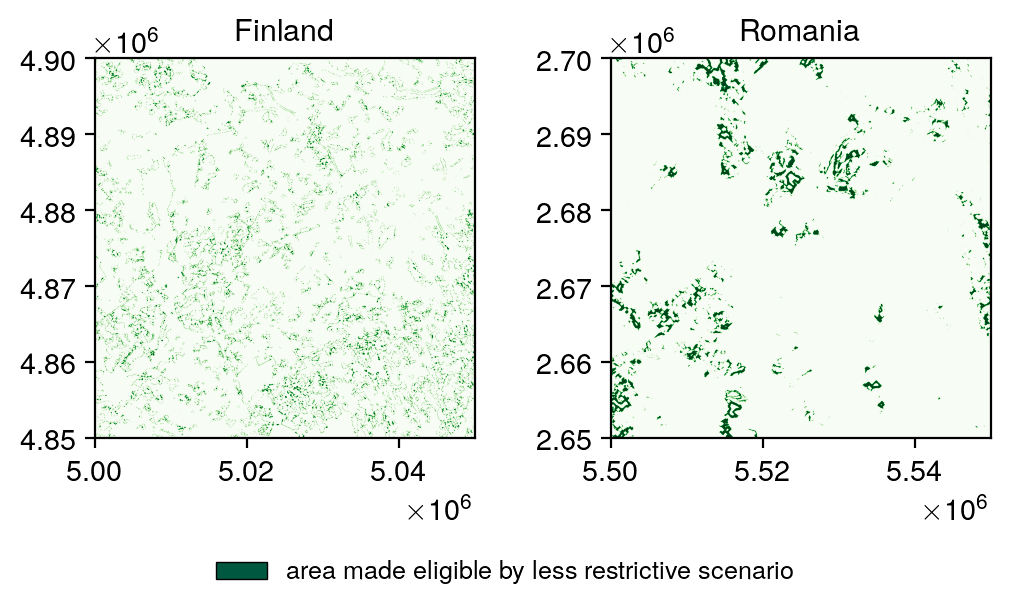

In [155]:
cmap = pltc.LinearSegmentedColormap.from_list(
    "", ['white', lighten_color(clrs['green'], 1.2)]
)

fig, ax = plt.subplots(1, 2, figsize = figsize(1), dpi = 200)

show(fin1-fin0, transform = tf, cmap = 'Greens', ax = ax[0] ) 
ax[0].set_ylim(4850000, 4900000)
ax[0].set_xlim(5000000, 5050000)
ax[0].set_title('Finland')

show(ro1-ro0, transform = rf, cmap = 'Greens', ax = ax[1] ) 
ax[1].set_ylim(2650000, 2700000)
ax[1].set_xlim(5500000, 5550000)
ax[1].set_title('Romania')


txt = 'area made eligible by less restrictive scenario' 

patches = [mpatches.Patch(facecolor=c, edgecolor = 'k', lw = .5, label=l) for l,c in zip([txt],[lighten_color(clrs['green'], 1.2)])]   
fig.legend(handles = patches, loc = 'lower center', ncol = 1, bbox_to_anchor=(.5, -0.015), frameon=False,  fontsize = 'small')

fig.tight_layout(pad = 2)
fig.savefig(ROOT + 'results/plots/structure.pdf', dpi = 200)


### old stuff

In [ ]:
# Forest Plots

urban_distance = 
forest_shares = [0,5,10,20]
d={}

for forest_share in forest_shares:
    with rio.open(ROOT + f'data/country_landuse_results/Germany-base-{urban_distance}-30-{forest_share}.tif') as f:
        d[int(forest_share)] = f.read(1)
        transform = f.transform

In [ ]:
germany = gpd.read_file(ROOT+'data/country_shapes/Germany.gpkg').to_crs(3035)

fig, ax = plt.subplots(1, 4, figsize = (8,6), dpi = 150) 

def area_share(mask):
    area = mask.sum().astype(float)*50**2
    share = area/germany.geometry.area.values[0]
    return int(area/1000000), round(share*100, 2)
    

show(d[0], transform=transform, cmap = 'Greens', ax=ax[0])
germany.plot(ax=ax[0], facecolor = 'none', edgecolor = 'k')
ax[0].set_title(f'area: {area_share(d[0])[0]} km**2, c. share {area_share(d[0])[1]}%', fontsize = 6, y = 1.1)

show(d[5], transform=transform, cmap = 'Greens', ax=ax[1])
germany.plot(ax=ax[1], facecolor = 'none', edgecolor = 'k')
ax[1].set_title(f'area: {area_share(d[5])[0]}  km**2, c. share {area_share(d[5])[1]}%', fontsize = 6, y = 1.1)

show(d[10], transform=transform, cmap = 'Greens', ax=ax[2])
germany.plot(ax=ax[2], facecolor = 'none', edgecolor = 'k')
ax[2].set_title(f'area: {area_share(d[10])[0]}  km**2, c. share {area_share(d[10])[1]}%', fontsize = 6, y = 1.1)

show(d[20], transform=transform, cmap = 'Greens', ax=ax[3])
germany.plot(ax=ax[3], facecolor = 'none', edgecolor = 'k')
ax[3].set_title(f'area: {area_share(d[20])[0]}  km**2, c. share {area_share(d[20])[1]}%', fontsize = 6, y = 1.1)

fig.suptitle('Germany total landuse, forest share 0%, 5%, 10% 20%. Urban distance: 1000m', y=0.75, fontsize = 10)

plt.savefig(ROOT + r'presentations\landuse_ud1000.png', bbox_inches = 'tight', dpi = 150)

### 5.2 Technical Potential

In [68]:
cntry = 'Luxembourg'
scenario = 'base'
urban_distances = ['400', '600', '800', '1000']
slopes = ['15', '30']
forest_shares = ['0', '5', '10', '20']
turbines = ['Vestas_V90_3MW', 'Vestas_V112_3MW', ('Vestas_V90_3MW', 'Vestas_V112_3MW')] 

In [69]:
store = pd.HDFStore(ROOT + f'data/country_generation_potential/{cntry}.h5')
keys = store.keys()
store.close()
keys

['/base-1000-30-5-5-Vestas_V90_3MW-Vestas_V112_3MW']

In [ ]:
fig, ax = plt.subplots(figsize = (8,5), dpi = 100)

for ts in store.keys():
    ax.plot(store[ts].resample('y').sum().sum(axis=1)/1000000, label = ts)

ax.set_ylabel('TWh/year')
ax.set_title('Germany: yearly generation timeseries 96 configurations') 

#ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.4), ncol=2, frameon=False, fontsize=8)
plt.savefig(ROOT + r'presentations\results1.png', bbox_inches = 'tight', dpi = 150)

In [ ]:
fig, ax = plt.subplots(figsize = (8,5), dpi = 100) 

for urban_distance in urban_distances:
    for slope in slopes: 
        for turbine in turbines:
            
            ax.scatter(x = len(gpd.read_file(ROOT +f'data/country_turbine_placements/{cntry}-{scenario}-{urban_distance}-{slope}-{concat_turbine_tuple(turbine)}.gpkg')),
                       y = float(store[f'{scenario}-{urban_distance}-{slope}-{concat_turbine_tuple(turbine)}'].resample('y').sum().sum(axis=1).mean()/1000000),
                       label = f'{scenario}-{urban_distance}-{slope}-{concat_turbine_tuple(turbine)}')

ax.set_ylabel('TWh/year')
ax.set_xlabel('# of turbines')
ax.set_title('Germany: # of turbines vs. avg. yearly generation') 
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.25), ncol=2, frameon=False, fontsize=8)
plt.savefig(r'C:\CaT\Masterthesis\repository\presentations\results2.png', bbox_inches = 'tight', dpi = 150)

In [ ]:
fig, ax = plt.subplots(figsize = (8,5), dpi = 100) 

for urban_distance in urban_distances:
    for slope in slopes:
        for forest_share in forest_shares:
            for turbine in turbines:
            
                ax.scatter(x = urban_distance,
                               y = float(store[f'{scenario}-{urban_distance}-{slope}-{forest_share}-{concat_turbine_tuple(turbine)}'].resample('y').sum().sum(axis=1).mean()/1000000),
                               label = f'{scenario}-{urban_distance}-{slope}-{forest_share}-{concat_turbine_tuple(turbine)}')

ax.set_ylabel('MWh/year')
ax.set_xlabel('distance to urban fabric [m]')
ax.set_title('Germany: distance to urban fabric vs. avg. yearly generation') 
#ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.45), ncol=2, frameon=False, fontsize=8)
plt.savefig(ROOT + r'presentations\results3.png', bbox_inches = 'tight', dpi = 150)

In [ ]:
fig, ax = plt.subplots(figsize = (8,5), dpi = 100) 

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=4, frameon=False, fontsize=8)

colors = ['#8dd3c7','#feffb3','#bfbbd9','#fa8174','#81b1d2','#fdb462','#b3de69','#bc82bd','#ccebc4','#ffed6f']
color_d = {urban_distances[i]:colors[i] for i in range(len(urban_distances))}

for urban_distance in urban_distances:
    for slope in slopes:
        for forest_share in forest_shares:
            for turbine in turbines[2]:
            
                ax.scatter(x = forest_share,
                           y = float(store[f'{scenario}-{urban_distance}-{slope}-{forest_share}-{concat_turbine_tuple(turbine)}'].resample('y').sum().sum(axis=1).mean()/1000000),
                           label = f'{urban_distance}m',
                           color = color_d[urban_distance]
                           )

ax.set_ylim(0)    
ax.set_ylabel('MWh/year')
ax.set_xlabel('forest_share [%]')
ax.set_title('Germany: share of forest used vs. avg. yearly generation') 

legend_without_duplicate_labels(ax)

plt.savefig(ROOT + r'presentations\results4.png', bbox_inches = 'tight', dpi = 150)

In [ ]:
fig, ax = plt.subplots(figsize = (8,5), dpi = 100) 

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=4, frameon=False, fontsize=8)

colors = ['#8dd3c7','#feffb3','#bfbbd9','#fa8174','#81b1d2','#fdb462','#b3de69','#bc82bd','#ccebc4','#ffed6f']
color_d = {forest_shares[i]:colors[i] for i in range(len(forest_shares))}

for urban_distance in urban_distances:
    for slope in slopes:
        for forest_share in forest_shares:
            for turbine in turbines:
            
                ax.scatter(x = urban_distance,
                           y = float(store[f'{scenario}-{urban_distance}-{slope}-{forest_share}-{concat_turbine_tuple(turbine)}'].resample('y').sum().sum(axis=1).mean()/1000000),
                           label = f'{forest_share}%',
                           color = color_d[forest_share]
                           )

ax.set_ylim(750)    
ax.set_ylabel('TWh/year')
ax.set_xlabel('forest_share [%]')
ax.set_title('Germany: share of forest used vs. avg. yearly generation') 

legend_without_duplicate_labels(ax)

plt.savefig(ROOT + r'presentations\results4.png', bbox_inches = 'tight', dpi = 150)

In [ ]:
fig, ax = plt.subplots(figsize = (8,5), dpi = 100) 

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=4, frameon=False, fontsize=8)

colors = ['#8dd3c7','#feffb3','#bfbbd9','#fa8174','#81b1d2','#fdb462','#b3de69','#bc82bd','#ccebc4','#ffed6f']
color_d = {turbines[i]:colors[i] for i in range(len(turbines))}

for urban_distance in urban_distances:
    for slope in slopes:
        for forest_share in forest_shares:
            for turbine in turbines:
            
                ax.scatter(x = forest_share,
                           y = float(store[f'{scenario}-{urban_distance}-{slope}-{forest_share}-{concat_turbine_tuple(turbine)}'].resample('y').sum().sum(axis=1).mean()/1000000),
                           label = f'{concat_turbine_tuple(turbine)}',
                           color = color_d[turbine]
                           )

ax.set_ylim(0)    
ax.set_ylabel('MWh/year')
ax.set_xlabel('forest_share [%]')
ax.set_title('Germany: share of forest used vs. avg. yearly generation') 

legend_without_duplicate_labels(ax)

plt.savefig(ROOT + r'presentations\results4.png', bbox_inches = 'tight', dpi = 150)

In [515]:
store = pd.HDFStore(ROOT + f'data/country_generation_potential/Germany.h5')
keys = store.keys()

#keys

a = store['/base-1000-30-5-5-W2E_151_4800kW-W2E_165_5200kW']
b = store['/base-1000-30-5-5-Vestas_V90_3MW-Vestas_V112_3MW']

store.close()

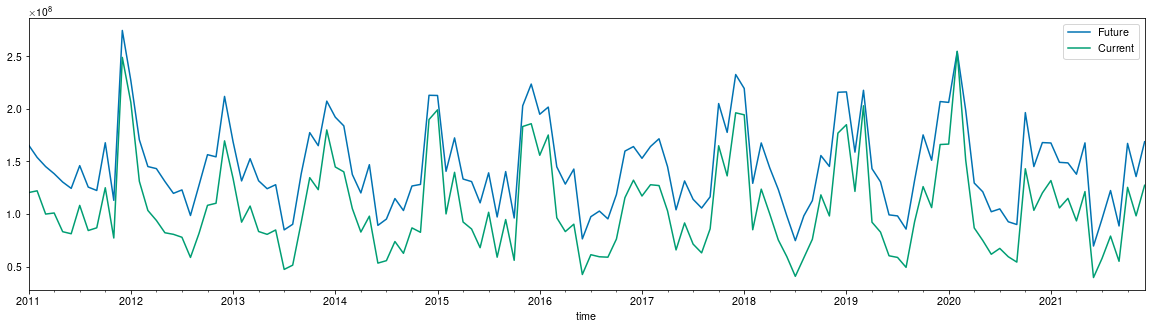

In [523]:
fig, ax = plt.subplots(figsize = (20,5))

a.resample('m').sum().sum(axis =1).plot(ax=ax, label = 'Future')
b.resample('m').sum().sum(axis =1).plot(ax=ax, label = 'Current')

ax.legend()

## 5. Conclusion